In [1]:
#CryptoCurrency price predictor
#2022/3/19
#Ehsan Mokhtari
#updated (2023/1/17)

In [2]:
#import the requisite libraries for processing and retrieving data in JSON format
import json
import requests

In [3]:
#and importing data analysis and visualization tools (my favorite libraries ever :)
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
%matplotlib inline

In [4]:
#using this libraries for measuring MAE, MSE and R2 scores for each neural network models
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [5]:
# CryptoCompare (www.cryptocompare.com) is a free website that provides the latest cryptocurrency prices data sets (in JSON format) via its API
cryptocurrency = 'ETH'  # You can use 'BTC' or any other cryptocurrency to fetch its price data
api_url = f'https://min-api.cryptocompare.com/data/histoday?fsym={cryptocurrency}&tsym=USD&limit=500'

# Fetching raw JSON data
raw_json_data = requests.get(api_url)

# Processing raw data to convert it into a useful tabular format
data_set = pandas.DataFrame(json.loads(raw_json_data.content)['Data'])
data_set = data_set.set_index('time')
data_set.index = pandas.to_datetime(data_set.index, unit='s')
target_column = 'close'

In [6]:
data_set.tail(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2023-03-21,1838.29,1724.38,1738.45,424932.74,7.610620e+08,1807.45,direct,
2023-03-22,1822.96,1717.19,1807.45,464597.07,8.261277e+08,1738.86,direct,
2023-03-23,1858.54,1733.86,1738.86,417373.61,7.498578e+08,1817.28,direct,
2023-03-24,1821.91,1728.85,1817.28,390968.48,6.923881e+08,1751.74,direct,
2023-03-25,1764.13,1722.99,1751.74,163000.53,2.850613e+08,1729.04,direct,


In [7]:
#as you can see, the JSON data is now converted to a tabular format but needs some cleaning

In [8]:
# Dropping unnecessary columns from the table
data_set.drop(["conversionType", "conversionSymbol","volumefrom", "volumeto"], axis='columns', inplace=True)

# The cleaned data is now ready for further processing
data_set.tail(5)

,high,low,open,close
time,,,,
2023-03-21,1838.29,1724.38,1738.45,1807.45
2023-03-22,1822.96,1717.19,1807.45,1738.86
2023-03-23,1858.54,1733.86,1738.86,1817.28
2023-03-24,1821.91,1728.85,1817.28,1751.74
2023-03-25,1764.13,1722.99,1751.74,1729.04


In [9]:
#now data is ready in our suitable tabular format for processing

In [10]:
# Starting the spliting process
# First, we need to separate our train and test data for the learning process
# We will use 80% of our data for training and 20% for testing
test_ratio = 0.2
split_index = len(data_set) - int(test_ratio * len(data_set))
train_data = data_set.iloc[:split_index]
test_data = data_set.iloc[split_index:]

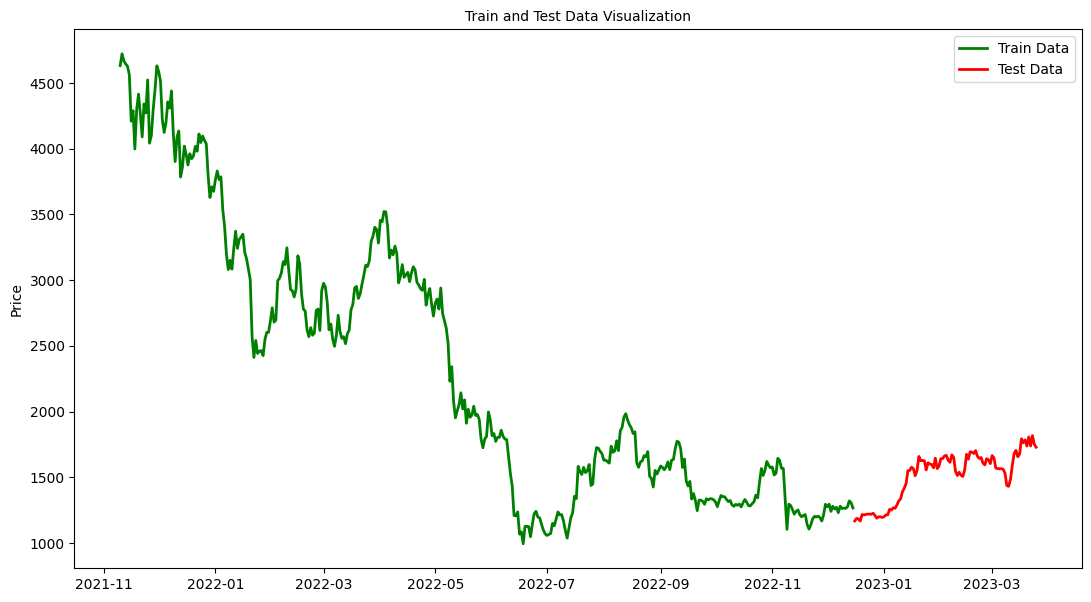

In [11]:
def visualize_data(train, test, train_label='Train Data', test_label='Test Data', plot_title='', line_width=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(train, label=train_label, linewidth=line_width, color="green")
    ax.plot(test, label=test_label, linewidth=line_width, color="red")
    ax.set_ylabel('Price', fontsize=10)
    ax.set_title(plot_title, fontsize=10)
    ax.legend(loc='best', fontsize=10)

visualize_data(train_data[target_column], test_data[target_column], 'Train Data', 'Test Data', plot_title='Train and Test Data Visualization')

In [12]:
#normalizing and preparing data for training process
#i didn't write these four functions by my own and i just get them from github to save my time btw :)
def normalize_zero_base(dataframe):
    #This function normalizes the given pandas dataframe using a zero-base normalization method.
    return (dataframe - dataframe.iloc[0]) / dataframe.iloc[0]

def normalize_min_max(dataframe):
    #This function normalizes the pandas dataframe using a min-max normalization method.
    return (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min())

def extract_window_data(dataframe, window_length=5, zero_based=True):
    windowed_data = []
    for index in range(len(dataframe) - window_length):
        temp = dataframe[index: (index + window_length)].copy()
        if zero_based:
            temp = normalize_zero_base(temp)
        windowed_data.append(temp.values)
    return numpy.array(windowed_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.25):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [18]:
#as a first algorithm, we use convolutional neural network (CNN) as it it the most efficient algorithm for time-series.
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Activation
from tensorflow.keras.models import Sequential
def build_cnn_model(input_data, output_size, filters=64, kernel_size=3, activ_func='linear',
                    dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [19]:
# default parameters for model training
window_len = 5
zero_base = True
epochs = 20
batch_size = 32

In [20]:
#tttttttttttttttttttttttttttttttrain cnn model with our data_set
train, test, X_train, X_test, y_train, y_test = prepare_data(
    data_set, target_column, window_len=window_len, zero_base=zero_base, test_size=test_ratio)
model = build_cnn_model(
    X_train, output_size=1)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 2s 31ms/step - loss: 0.0111 - val_loss: 0.0031
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0026
Epoch 3/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0027
Epoch 4/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 5/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 6/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 7/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 8/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 9/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 10/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 11/20
13/1

In [21]:
#measuring MAE, MSE and R2 scores for CNN 
targets = test_data[target_column][window_len:]
preds = model.predict(X_test).squeeze()
print('MAE = '+ str(mean_absolute_error(preds, y_test)))
MAE = mean_squared_error(preds, y_test)
print('MSE = ' + str(MAE))
R2 = r2_score(y_test, preds)
print('R2 = ' + str(R2))

3/3 [==============================] - 0s 6ms/step
MAE = 0.03163205767333455
MSE = 0.0019498545572762952
R2 = 0.49865157053770215


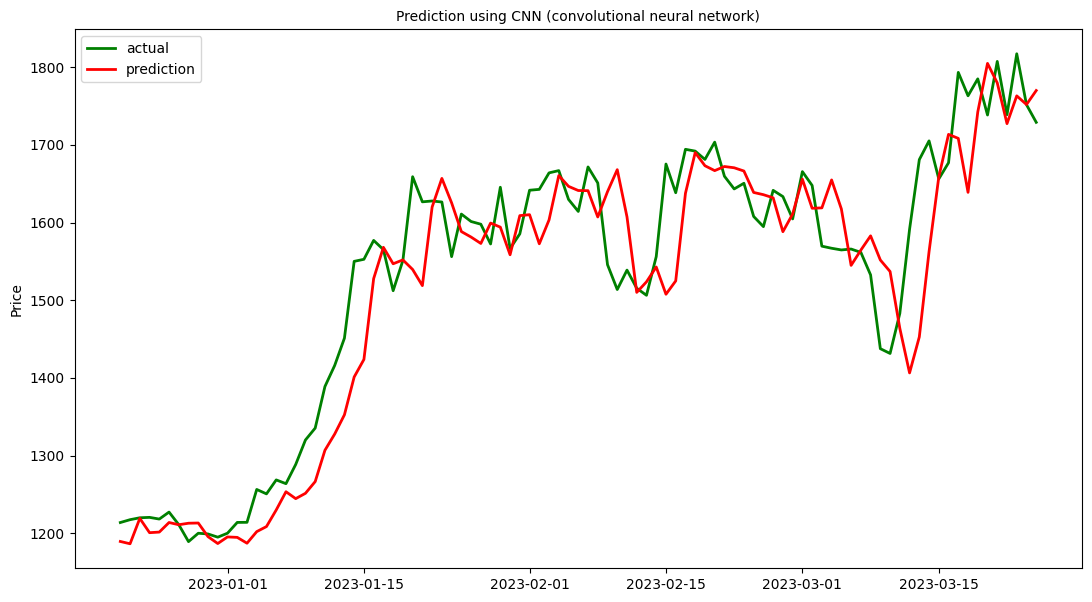

In [22]:
#and finally visualizing the prediction results
preds = test_data[target_column].values[:-window_len] * (preds + 1)
preds = pandas.Series(index=targets.index, data=preds)
visualize_data(targets, preds, 'actual', 'prediction', plot_title='Prediction using CNN (convolutional neural network)')

In [23]:
#next, we use RNN (recurrent neural network). this neural network is good for processing sequential data.
from tensorflow.keras.layers import  Dropout, Dense, Activation, SimpleRNN

def build_rnn_model(input_data, output_size, units=64, activ_func='linear',
                    dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation='relu', input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [24]:
#tttttttttttttttttttttttttttttttrain RNN model with our data_set
train, test, X_train, X_test, y_train, y_test = prepare_data(
    data_set, target_column, window_len=window_len, zero_base=zero_base, test_size=test_ratio)
model = build_rnn_model(
    X_train, output_size=1)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 3s 47ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 2/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 3/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 4/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 5/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 9.9200e-04
Epoch 6/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 7/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 8/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 9.4116e-04
Epoch 9/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 10/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 9.2979e-04
Epo

In [25]:
#measuring MAE, MSE and R2 scores for RNN
targets = test_data[target_column][window_len:]
preds = model.predict(X_test).squeeze()
print('MAE = '+ str(mean_absolute_error(preds, y_test)))
MAE = mean_squared_error(preds, y_test)
print('MSE = ' + str(MAE))
R2 = r2_score(y_test, preds)
print('R2 = ' + str(R2))

3/3 [==============================] - 0s 9ms/step
MAE = 0.022507496545801985
MSE = 0.0009702733975521067
R2 = 0.750522395531234


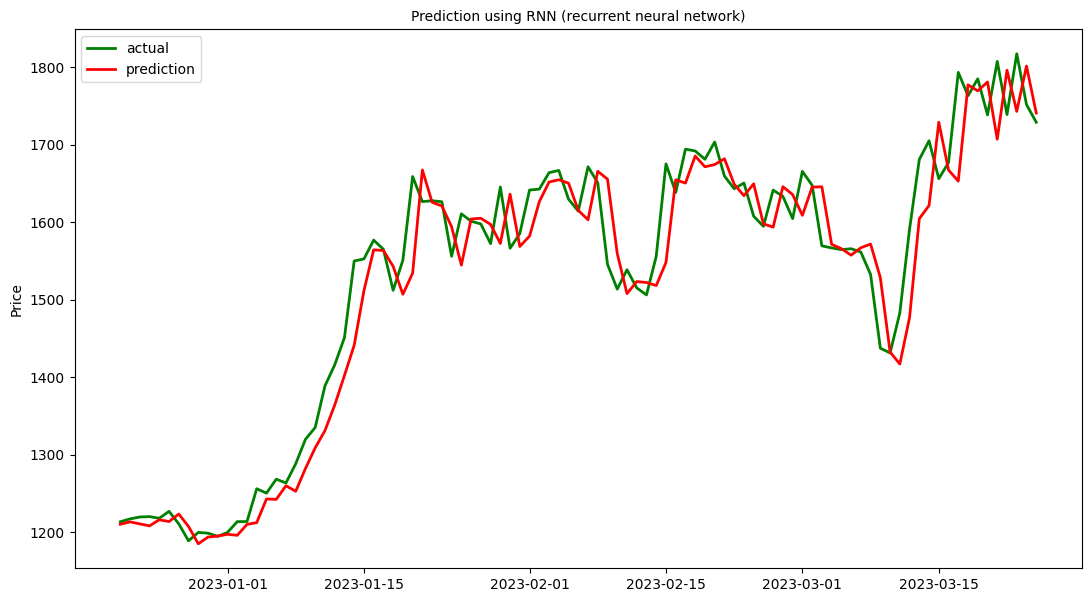

In [26]:
#and finally visualizing the prediction results of RNN
preds = test_data[target_column].values[:-window_len] * (preds + 1)
preds = pandas.Series(index=targets.index, data=preds)
visualize_data(targets, preds, 'actual', 'prediction', plot_title='Prediction using RNN (recurrent neural network)')

In [29]:
#3. we want to use LSTM (long short-term memory networks) - it has similar mechanism to RNN btw.
from tensorflow.keras.layers import  LSTM
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [30]:
#training our lstm model
train, test, X_train, X_test, y_train, y_test = prepare_data(
    data_set, target_column, window_len=window_len, zero_base=zero_base, test_size=test_ratio)
model = build_lstm_model(
    X_train, output_size=1)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 6s 93ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 2/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 3/20
13/13 [==============================] - 0s 17ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 4/20
13/13 [==============================] - 0s 25ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 5/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 6/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 7/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 8/20
13/13 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 9/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 10/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 11/

In [31]:
#measuring MAE, MSE and R2 scores for LSTM
targets = test_data[target_column][window_len:]
preds = model.predict(X_test).squeeze()
print('MAE = '+ str(mean_absolute_error(preds, y_test)))
MAE = mean_squared_error(preds, y_test)
print('MSE = ' + str(MAE))
R2 = r2_score(y_test, preds)
print('R2 = ' + str(R2))

3/3 [==============================] - 1s 5ms/step
MAE = 0.02326916434183304
MSE = 0.0010382832642598372
R2 = 0.733035634924079


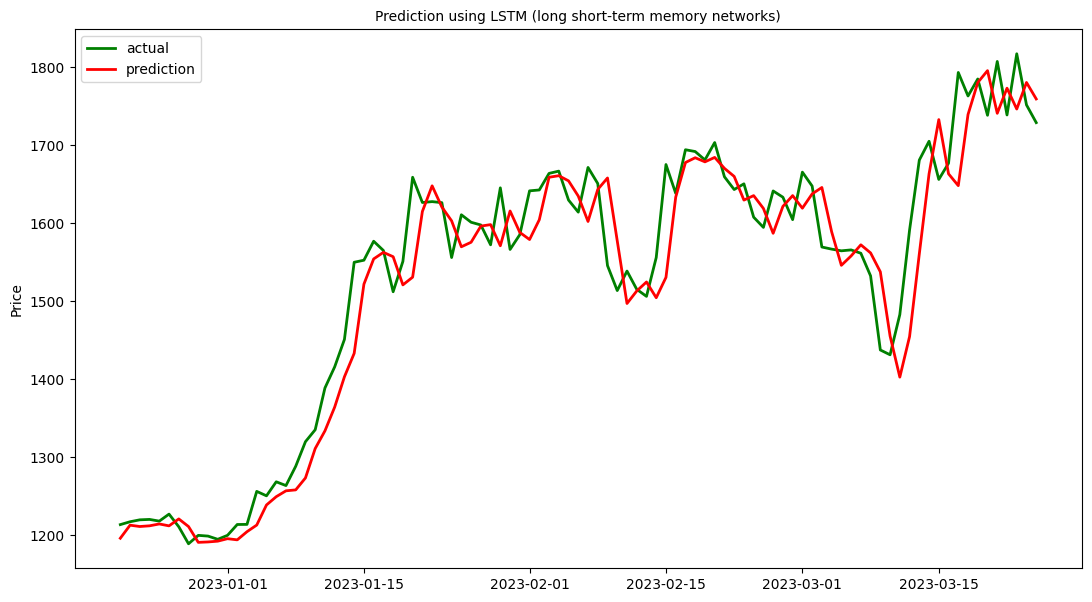

In [32]:
#and finally visualizing the prediction results of LSTM
preds = test_data[target_column].values[:-window_len] * (preds + 1)
preds = pandas.Series(index=targets.index, data=preds)
visualize_data(targets, preds, 'actual', 'prediction', plot_title='Prediction using LSTM (long short-term memory networks)')

In [33]:
# now we want to process our data using GRU (Gated recurrent units)
#GRU, LSTM and RNN nearly have the same mechanism with little differences.
from tensorflow.keras.layers import  GRU
def build_gru_model(input_data, output_size, units=64, activ_func='linear', dropout=0.2,
                    loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(units=units, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [34]:
#train train train train
train, test, X_train, X_test, y_train, y_test = prepare_data(
    data_set, target_column, window_len=window_len, zero_base=zero_base, test_size=test_ratio)
model = build_gru_model(
    X_train, output_size=1)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 5s 84ms/step - loss: 0.0077 - val_loss: 0.0021
Epoch 2/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 3/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 4/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 5/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 6/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 7/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 8/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 9/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 10/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0027 - val_loss: 9.9404e-04
Epoch

In [35]:
#measuring MAE, MSE and R2 scores for GRU
targets = test_data[target_column][window_len:]
preds = model.predict(X_test).squeeze()
print('MAE = '+ str(mean_absolute_error(preds, y_test)))
MAE = mean_squared_error(preds, y_test)
print('MSE = ' + str(MAE))
R2 = r2_score(y_test, preds)
print('R2 = ' + str(R2))

3/3 [==============================] - 1s 9ms/step
MAE = 0.02259494576886005
MSE = 0.0009922818309874
R2 = 0.7448635665193293


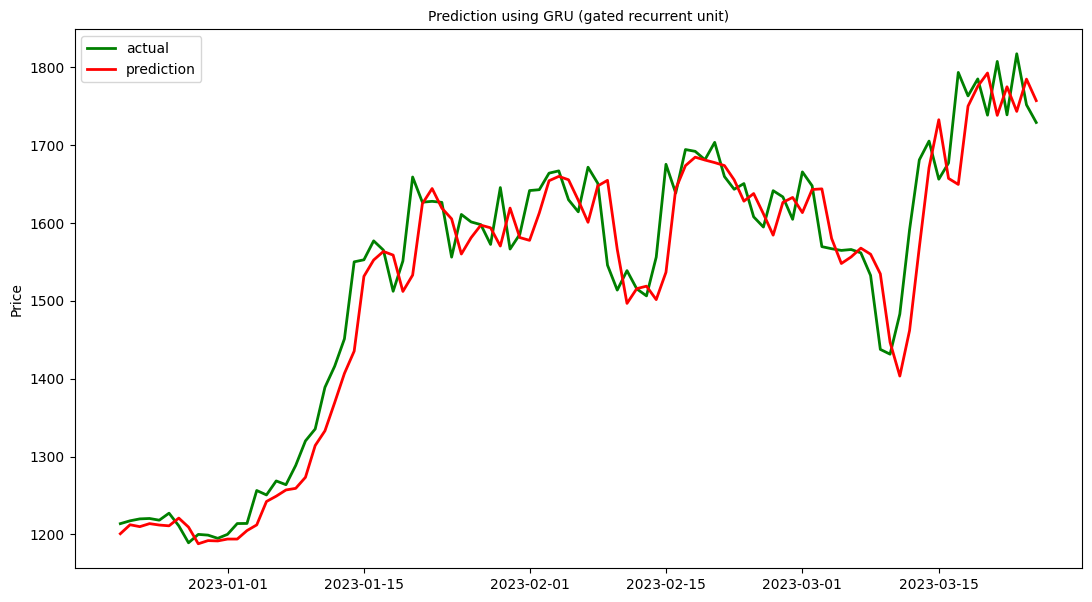

In [36]:
#visualizing the prediction results of LSTM
preds = test_data[target_column].values[:-window_len] * (preds + 1)
preds = pandas.Series(index=targets.index, data=preds)
visualize_data(targets, preds, 'actual', 'prediction', plot_title='Prediction using GRU (gated recurrent unit)')

In [37]:
# 5. using FNN (feedforward neural network)
def build_fnn_model(input_data, output_size, num_hidden_layers=1, hidden_units=64,
                    activ_func='relu', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(Flatten(input_shape=(input_data.shape[1], input_data.shape[2])))

    for i in range(num_hidden_layers):
        model.add(Dense(units=hidden_units))
        if activ_func != 'linear':
            model.add(Activation(activ_func))
        if dropout > 0:
            model.add(Dropout(dropout))

    model.add(Dense(units=output_size))
    if activ_func != 'linear':
        model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [38]:
#training level
train, test, X_train, X_test, y_train, y_test = prepare_data(
    data_set, target_column, window_len=window_len, zero_base=zero_base, test_size=test_ratio)
model = build_fnn_model(
    X_train, output_size=1)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 1s 25ms/step - loss: 0.0116 - val_loss: 0.0044
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0044
Epoch 3/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.0044
Epoch 4/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0040
Epoch 5/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0087 - val_loss: 0.0015
Epoch 6/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0015
Epoch 7/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0016
Epoch 8/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0072 - val_loss: 0.0016
Epoch 9/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.0016
Epoch 10/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0072 - val_loss: 0.0015
Epoch 11/20
13/13

In [40]:
#measuring MAE, MSE and R2 scores for FNN
targets = test_data[target_column][window_len:]
preds = model.predict(X_test).squeeze()
print('MAE = '+ str(mean_absolute_error(preds, y_test)))
MAE = mean_squared_error(preds, y_test)
print('MSE = ' + str(MAE))
R2 = r2_score(y_test, preds)
print('R2 = ' + str(R2))

3/3 [==============================] - 0s 9ms/step
MAE = 0.031056770505392725
MSE = 0.001616317087758845
R2 = 0.584411036999132


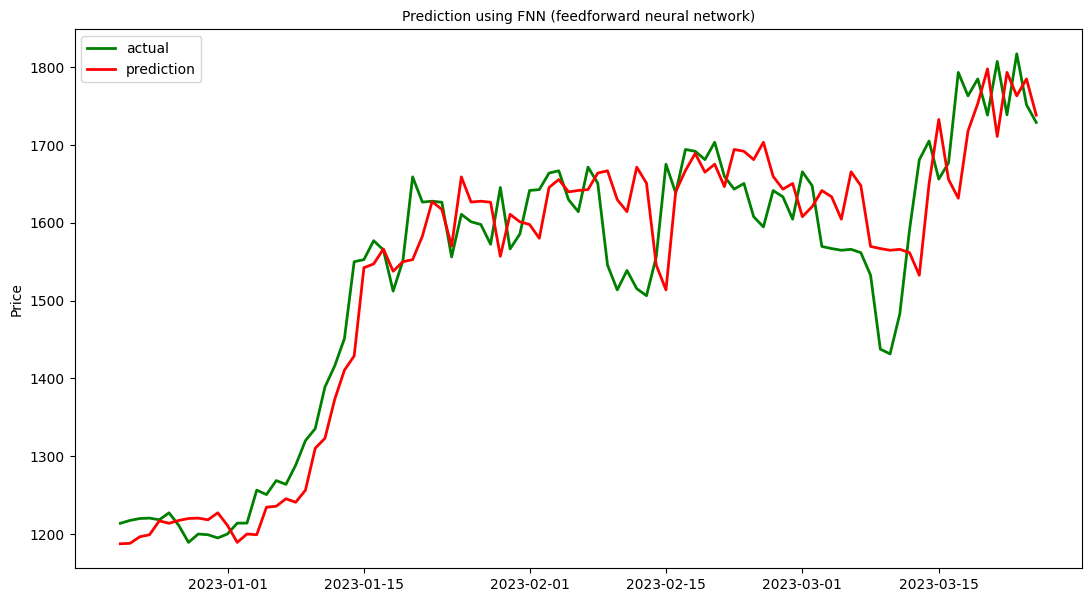

In [41]:
#results of FNN prediction
preds = test_data[target_column].values[:-window_len] * (preds + 1)
preds = pandas.Series(index=targets.index, data=preds)
visualize_data(targets, preds, 'actual', 'prediction', plot_title='Prediction using FNN (feedforward neural network)')

In [42]:
# 6. using dilated CNN
from keras.layers import SpatialDropout1D
def build_dilated_cnn_model(input_data, output_size, filters=64, kernel_size=3, activ_func='linear',
                            dilation_rate=1, dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(Conv1D(filters=filters,kernel_size=kernel_size,padding='causal',activation="relu",dilation_rate=dilation_rate,input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(SpatialDropout1D(dropout))
    model.add(Conv1D(filters=filters,kernel_size=kernel_size,padding="causal", activation="relu",dilation_rate=dilation_rate))
    model.add(MaxPooling1D())
    model.add(Flatten())
    # add additional dense layers if desired
    # output layer
    model.add(Dense(units=output_size))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [43]:
#this is a school for our dataset because it learns!
train, test, X_train, X_test, y_train, y_test = prepare_data(
    data_set, target_column, window_len=window_len, zero_base=zero_base, test_size=test_ratio)
model = build_dilated_cnn_model(
    X_train, output_size=1)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 2s 26ms/step - loss: 0.0079 - val_loss: 0.0028
Epoch 2/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 3/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 4/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 5/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 6/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 7/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 8/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 9/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 10/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 11/

In [44]:
#measuring MAE, MSE and R2 scores for dilated_cnn
targets = test_data[target_column][window_len:]
preds = model.predict(X_test).squeeze()
print('MAE = '+ str(mean_absolute_error(preds, y_test)))
MAE = mean_squared_error(preds, y_test)
print('MSE = ' + str(MAE))
R2 = r2_score(y_test, preds)
print('R2 = ' + str(R2))

3/3 [==============================] - 0s 9ms/step
MAE = 0.032061993580549196
MSE = 0.0018922418682642474
R2 = 0.5134649990806174


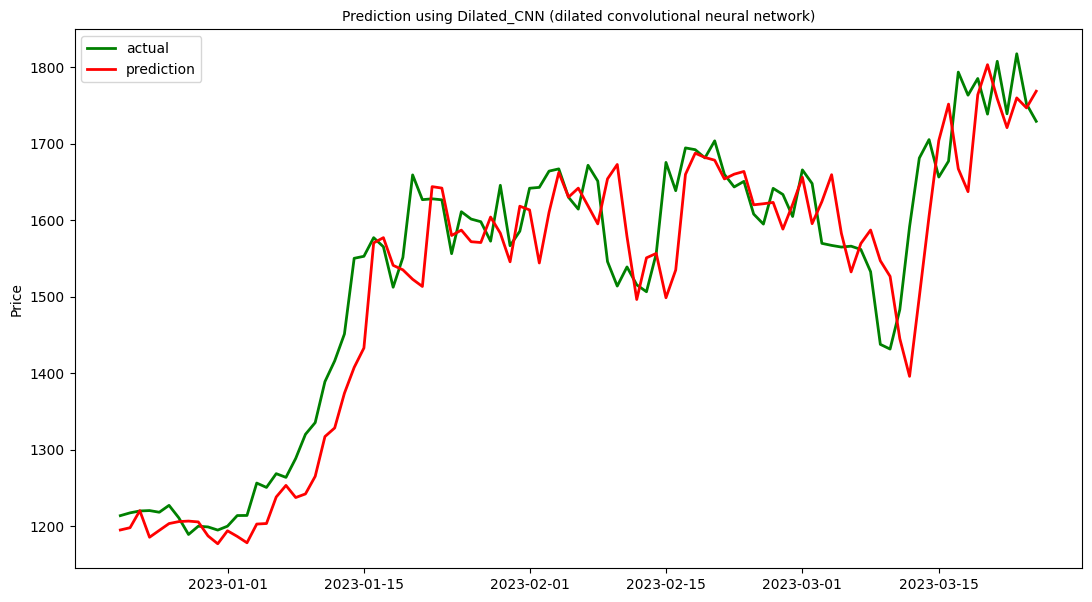

In [45]:
#showtime !
preds = test_data[target_column].values[:-window_len] * (preds + 1)
preds = pandas.Series(index=targets.index, data=preds)
visualize_data(targets, preds, 'actual', 'prediction', plot_title='Prediction using Dilated_CNN (dilated convolutional neural network)')

In [47]:
# 7 . multilayer perceptrons (MLP) simple and ready to mingle !
def build_mlp_model(input_data, output_size, hidden_units=[64], activ_func='relu',
                    dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    
    # Flatten input data into 1D array
    model.add(Flatten(input_shape=(input_data.shape[1], input_data.shape[2])))

    # Add hidden layers with specified number of units and activation function
    for num_units in hidden_units:
        model.add(Dense(units=num_units))
        model.add(Activation(activ_func))
        model.add(Dropout(dropout))

    # Output layer with specified number of units and activation function
    output_activation = 'linear' if output_size == 1 else 'softmax'
    model.add(Dense(units=output_size))
    model.add(Activation(output_activation))

    # Compile the MLP Model with Loss Function and Optimizer Specified
    model.compile(loss=loss, optimizer=optimizer)
    return(model)

In [48]:
#cooking stage!
train, test, X_train, X_test, y_train, y_test = prepare_data(
    data_set, target_column, window_len=window_len, zero_base=zero_base, test_size=test_ratio)
model = build_mlp_model(
    X_train, output_size=1)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 1s 24ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 2/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 3/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 4/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 5/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 6/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 7/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 8/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 9/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 10/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 9.4774e-04
Epoch 11/2

In [49]:
#measuring MAE, MSE and R2 scores for MLP
targets = test_data[target_column][window_len:]
preds = model.predict(X_test).squeeze()
print('MAE = '+ str(mean_absolute_error(preds, y_test)))
MAE = mean_squared_error(preds, y_test)
print('MSE = ' + str(MAE))
R2 = r2_score(y_test, preds)
print('R2 = ' + str(R2))

3/3 [==============================] - 0s 8ms/step
MAE = 0.022504534350717854
MSE = 0.0009600749083727596
R2 = 0.7531446406181168


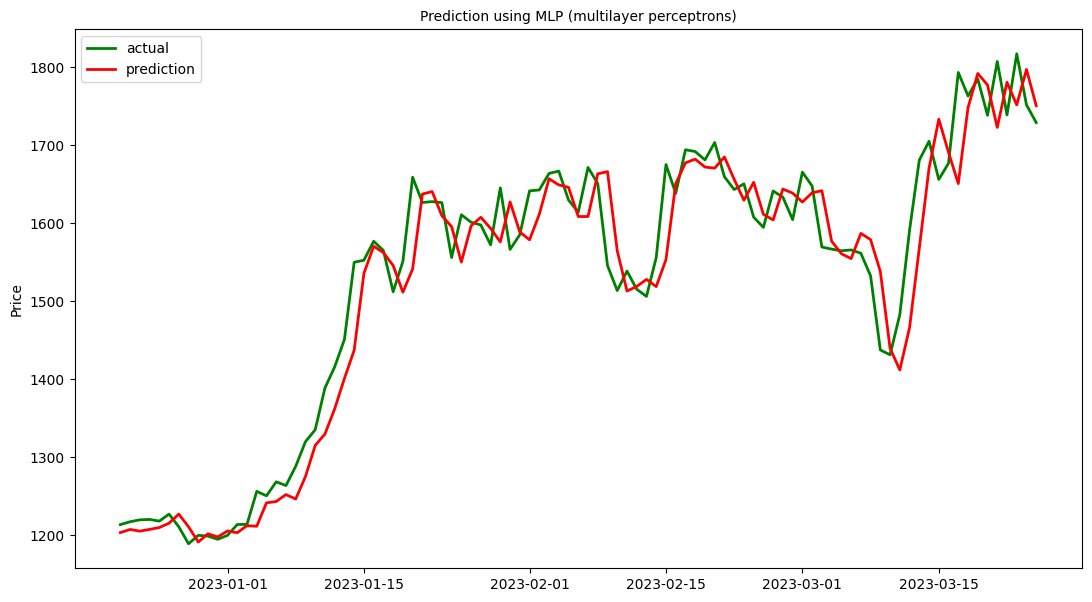

In [50]:
#showtime !
preds = test_data[target_column].values[:-window_len] * (preds + 1)
preds = pandas.Series(index=targets.index, data=preds)
visualize_data(targets, preds, 'actual', 'prediction', plot_title='Prediction using MLP (multilayer perceptrons)')

In [51]:
#we used 7 different NN algorithms to predict our prices. hope you enjoy it <3

In [52]:
#this file was updated at 2023/3/25 just for fixing some bugs and issues also for uploading on github.
#free to use if you want